# Fisher検定とPearsonのχ²検定のどちらを使うべきか

* 黒木玄
* 2022-08-13

誤り❌と正解⭕:

❌ Fisher検定は正確な検定である.<br>
⭕ Fisher検定のP値には過剰に大きくなりすぎる傾向がある.

❌ χ²検定はFisher検定の近似なので, Fisher検定よりも正確でないのは当然である.<br>
⭕ χ²検定はFisher検定とは違ってconditional testではない.<br>
⭕ χ²検定の性質をFisher検定の近似とみなして理解しようとすることは誤りである.<br>
⭕ χ²検定の方が第一種の過誤の確率が名目有意水準に近くなる場合が多い.

❌ 小さな値のセルを持つ分割表でχ²検定を使ってはいけない.<br>
⭕ 実際には多くの場合にはχ²検定を使っても大丈夫である.<br>
⭕ 小さな値のセルを持つ分割表でFisher検定を使うと検出力が低くなってしまう.

❌ 小さな値のセルを持つ分割表でχ²検定を使う場合にはYatesの連続性補正を使うべきである.<br>
⭕ χ²検定においてはいかなる場合もYatesの連続性補正は使うべきではない.<br>
⭕ Yatesの連続性補正されたχ²検定では, Fisher検定よりもP値がさらに過剰に大きめになる傾向がある.<br>
⭕ 第一種の過誤の確率を確実に有意水準以下に押さえたければ, Yatesの連続補正されたχ²検定ではなく, Fisher検定の方を使うべきである.  Yatesの連続補正されたχ²検定を使うことにメリットがある場面はないように思われる.

⭕ Fisher検定には, 第一種の過誤の確率を確実に名目有意水準以下にできるという利点がある.<br>
⭕ Fisher検定には, 第一種の過誤の確率が名目有意水準よりも過剰に小さくなり易いという欠点がある.<br>
⭕ Fisher検定の検出力はχ²検定よりも低い.

⭕ χ²検定には, 第一種の過誤の確率が名目有意水準に近くなるという利点がある.<br>
⭕ χ²検定の検出力はFisher検定よりも高い.<br>
⭕ χ²検定には, 第一種の過誤の確率が名目有意水準よりも少し大きくなる場合があるという欠点がある.

⭕ χ²検定を行うときにも, オッズ比などの信頼区間も計算しておくべきである.<br>
⭕ Rの`chisq.test`は信頼区間を表示してくれないので不便である.<br>
https://twitter.com/genkuroki/status/1496109997721538565<br>
⭕ Rで`chisq.test`と整合的な信頼区間を表示したいなら, 自分でその方法を探す必要がある.<br>
⭕ `chisq.test`と整合性がないWald型の信頼区間を表示してくれるパッケージならば容易に見つかる.

⭕ Fisher検定を行うときにも, オッズ比の信頼区間も計算しておくべきである.<br>
⭕ Rの`fisher.test`が表示するP値と信頼区間の間には整合性がない.<br>
https://twitter.com/genkuroki/status/1496064721652690946

__お勧め文献__

* [https://www.jstage.jst.go.jp/article/dds/30/3/30_235/_pdf](https://www.jstage.jst.go.jp/article/dds/30/3/30_235/_pdf)<br>
連載 第3回<br>
医学データの統計解析の基本 2つの割合の比較<br>
朝倉こう子・濱﨑俊光

In [1]:
using Distributions
using Random
using Roots
using StatsBase
using StatsFuns
using StatsPlots
default(size=(480, 300), titlefontsize=10, tickfontsize=6, guidefontsize=9)

safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_or_wald (generic function with 1 method)

In [3]:
function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [4]:
_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_fisher_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_or_fisher_sterne(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_fisher_sterne(fnch, a)
end

function confint_or_fisher_sterne(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_fisher_sterne(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        [first(ps), last(ps)]
    end
end

confint_or_fisher_sterne (generic function with 1 method)

In [5]:
function another_p(q, ω)
    u = q/(1 - q)
    p = ω*u/(1 + ω*u)
end

function sim(; m = 10, n = 10, q = 0.5, ω = 1, p = another_p(q, ω), L=10^5)
    pval_chisq  = similar(zeros(), L)
    pval_fisher = similar(zeros(), L)
    bin1, bin2 = Binomial(m, p), Binomial(n, q)
    Threads.@threads for i in 1:L
        a, c = rand(bin1), rand(bin2)
        b, d = m - a, n - c
        pval_chisq[i]  = pvalue_or_pearson_chisq(a, b, c, d; ω)
        pval_fisher[i] = pvalue_or_fisher_sterne(a, b, c, d; ω)
    end
    F = ecdf(pval_chisq)
    G = ecdf(pval_fisher)
    f(x) = F(x)
    g(x) = G(x)
    f, g
end

function plot_probalphaerror(; m = 10, n = 10, q = 0.5, ω = 1, L = 10^5, kwargs...)
    f, g = sim(; m, n, q, ω, L)
    
    xs = 0:0.001:1
    P1 = plot(legend=:topleft)
    plot!(xs, f; label="Pearson χ²")
    plot!(xs, g; label="Fisher", ls=:dash)
    plot!(identity; label="", c=:black, ls=:dot)
    plot!(xtick=0:0.1:1, ytick=0:0.1:1)
    plot!(xguide="α", yguide="probability of α-error")
    title!("m=$m, n=$n, q=$q, ω=$ω")
    plot!(; kwargs...)
    
    xs = 0:0.0001:0.1
    P2 = plot(legend=:topleft)
    plot!(xs, f; label="Pearson χ²")
    plot!(xs, g; label="Fisher", ls=:dash)
    plot!(identity; label="", c=:black, ls=:dot)
    plot!(xtick=0:0.01:1, ytick=0:0.01:1)
    plot!(xguide="α", yguide="probability of α-error")
    title!("m=$m, n=$n, q=$q, ω=$ω")
    plot!(; kwargs...)
    
    plot(P1, P2; size=(700, 350))
end

plot_probalphaerror (generic function with 1 method)

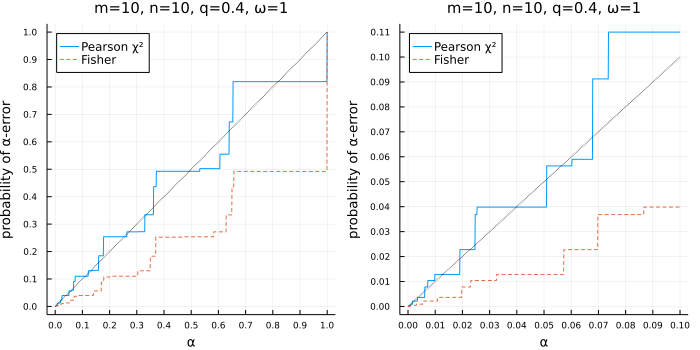

In [6]:
plot_probalphaerror(m = 10, n = 10, q = 0.4, ω = 1)

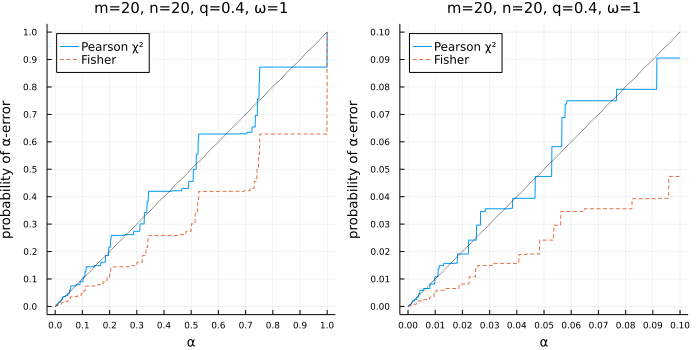

In [7]:
plot_probalphaerror(m = 20, n = 20, q = 0.4, ω = 1)

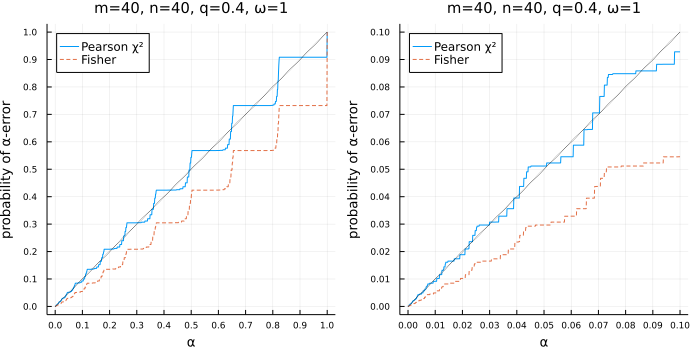

In [8]:
plot_probalphaerror(m = 40, n = 40, q = 0.4, ω = 1)

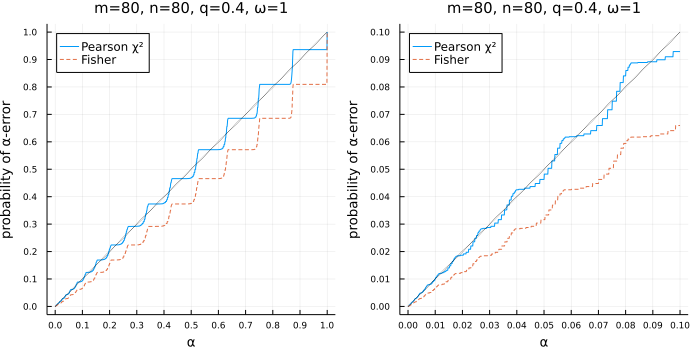

In [9]:
plot_probalphaerror(m = 80, n = 80, q = 0.4, ω = 1)

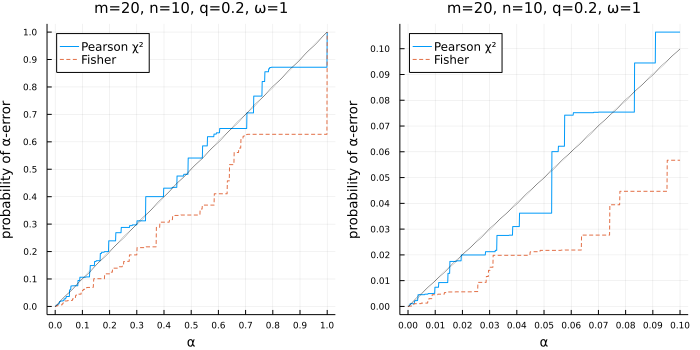

In [10]:
plot_probalphaerror(m = 20, n = 10, q = 0.2, ω = 1)

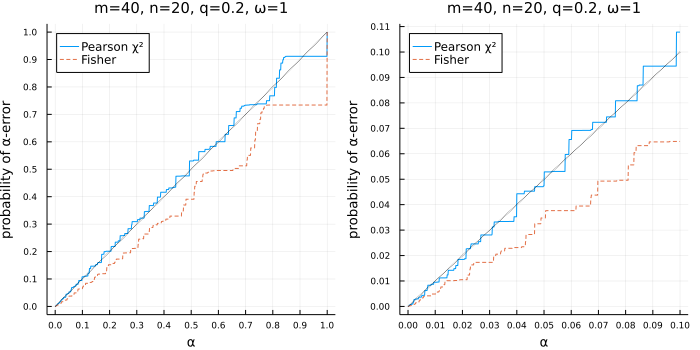

In [11]:
plot_probalphaerror(m = 40, n = 20, q = 0.2, ω = 1)

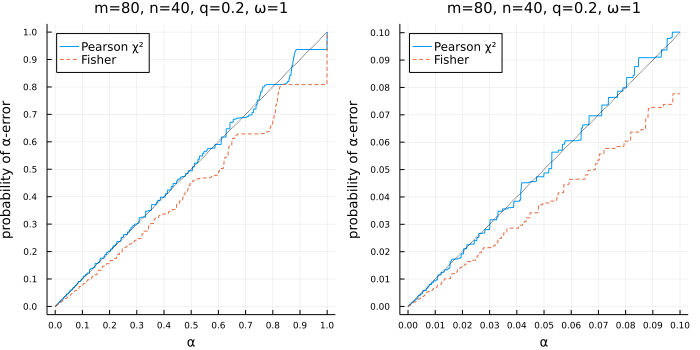

In [12]:
plot_probalphaerror(m = 80, n = 40, q = 0.2, ω = 1)

In [13]:
function mysupport(dist, c=5)
    μ, σ = mean(dist), std(dist)
    a = max(minimum(dist), round(Int, μ-c*σ))
    b = min(maximum(dist), round(Int, μ+c*σ))
    a:b
end

function power(pvaluefunc, m, n, q;
        ω = 1, p = another_p(q, ω), α = 0.05)
    bin1, bin2 = Binomial(m, p), Binomial(n, q)
    supp1, supp2 = mysupport(bin1), mysupport(bin2)
    sum(Iterators.product(supp1, supp2)) do (a, c)
        (pvaluefunc(a, m-a, c, n-c; ω) < α) * pdf(bin1, a) * pdf(bin2, c)
    end
end

power (generic function with 1 method)

In [14]:
function logtick(; xlim=(0.03, 500))
    xmin, xmax = xlim
    a = floor(Int, log10(xmin))
    b = ceil(Int, log10(xmax))
    nums =     [1, 2, 3, 4, 5, 6, 7, 8, 9]
    mask = Bool[1, 1, 0, 0, 1, 0, 0, 0, 0]
    
    logtick = foldl(vcat, ([10.0^k*x for x in nums if xmin ≤ 10.0^k*x ≤ xmax] for k in a:b))
    logticklabel_a = foldl(vcat,
        ([mask[i] ? string(round(10.0^k*x; digits=-k)) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in a:-1))
    logticklabel_b = foldl(vcat,
        ([mask[i] ? string(10^k*x) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in 0:b))
    logticklabel = vcat(logticklabel_a, logticklabel_b)
    (logtick, logticklabel)
end

function plot_powers(; m = 10, n = 10, q = 0.5, α = 0.05,
        ωmin = 0.01, ωmax = 100.0, kwargs...)
    f(ω) = power(pvalue_or_pearson_chisq, m, n, q; p=another_p(q, ω), α)
    g(ω) = power(pvalue_or_fisher_sterne, m, n, q; p=another_p(q, ω), α)
    plot(legend=:bottomright)
    plot!(f, ωmin, ωmax; label="Pearson χ²")
    plot!(g, ωmin, ωmax; label="Fisher", ls=:dash)
    plot!(xscale=:log10, xtick=logtick(xlim=(ωmin, ωmax)), ytick=0:0.05:1)
    plot!(xguide="ω", yguide="power")
    title!("m=$m, n=$n, q=$q, α=$α")
    plot!(; kwargs...)
end

plot_powers (generic function with 1 method)

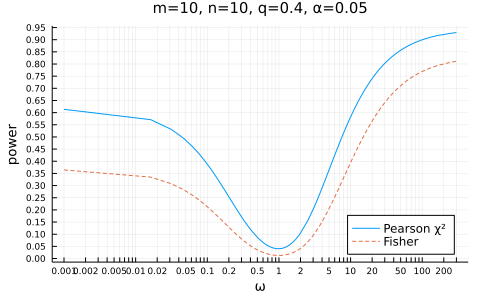

In [15]:
plot_powers(m = 10, n = 10, q = 0.4, α = 0.05, ωmin = 0.001, ωmax = 300.0)

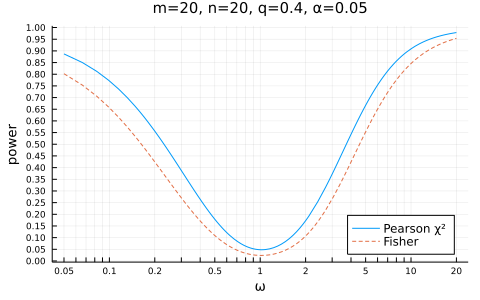

In [16]:
plot_powers(m = 20, n = 20, q = 0.4, α = 0.05, ωmin = 0.05, ωmax = 20.0)

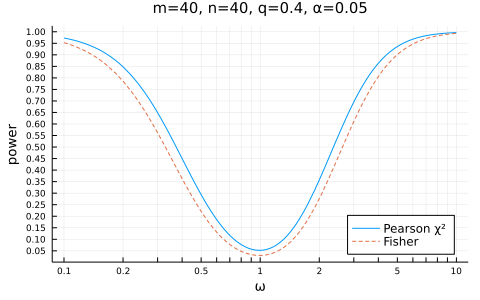

In [17]:
plot_powers(m = 40, n = 40, q = 0.4, α = 0.05, ωmin = 0.1, ωmax = 10.0)

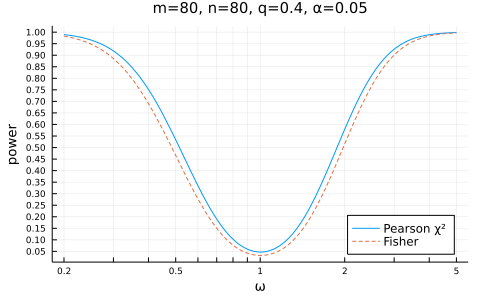

In [18]:
plot_powers(m = 80, n = 80, q = 0.4, α = 0.05, ωmin = 0.2, ωmax = 5.0)

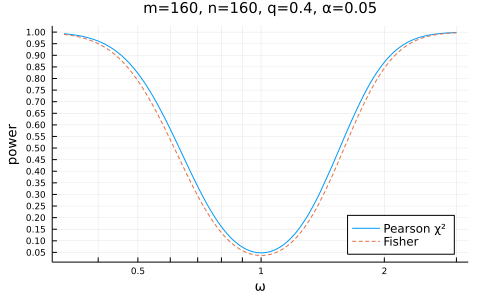

In [19]:
plot_powers(m = 160, n = 160, q = 0.4, α = 0.05, ωmin = 0.33, ωmax = 3.0)

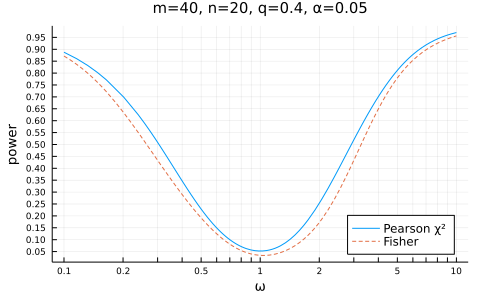

In [20]:
plot_powers(m = 40, n = 20, q = 0.4, α = 0.05, ωmin = 0.1, ωmax = 10.0)

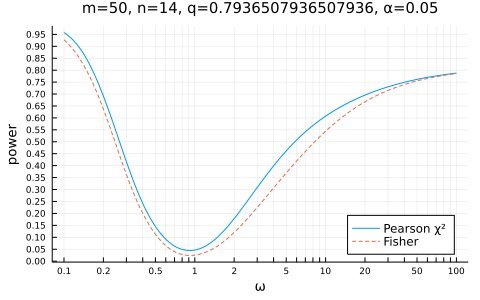

In [21]:
# 40, 10, 10, 4
plot_powers(m = 50, n = 14, q = 50/63, α = 0.05, ωmin = 0.1, ωmax = 100.0)

In [22]:
m, n, q = 50, 14, 50/63
ω = 7
@show power(pvalue_or_pearson_chisq, m, n, q; p=another_p(q, ω))
@show power(pvalue_or_fisher_sterne, m, n, q; p=another_p(q, ω));

power(pvalue_or_pearson_chisq, m, n, q; p = another_p(q, ω)) = 0.5415496553181354
power(pvalue_or_fisher_sterne, m, n, q; p = another_p(q, ω)) = 0.4594987393142976


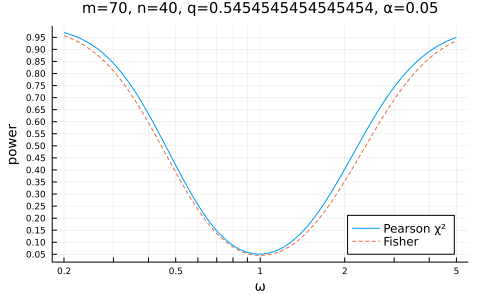

In [23]:
# 40, 30, 20, 20
plot_powers(m = 70, n = 40, q = 60/110, α = 0.05, ωmin = 0.2, ωmax = 5.0)

In [24]:
m, n, q = 70, 40, 60/110
ω = 2.5
@show power(pvalue_or_pearson_chisq, m, n, q; p=another_p(q, ω))
@show power(pvalue_or_fisher_sterne, m, n, q; p=another_p(q, ω));

power(pvalue_or_pearson_chisq, m, n, q; p = another_p(q, ω)) = 0.602837136107077
power(pvalue_or_fisher_sterne, m, n, q; p = another_p(q, ω)) = 0.543752512625262
